✅ Successfully loaded and parsed Greek and NRSV data.
✅ Calculated rhetorical deltas.

--- Sample of Calculated Deltas ---


,Worship & Praise,Judicial Wrath & Punitive Action,"Lament, Persecution & Endurance","Victory, Consolation & New-Creation Hope",Cosmic Warfare & Deception,Prophetic Exhortation & Warning,Theophanic Awe & Terror,Other/Neutral Content
unit_id,,,,,,,,
unit_001,-8.0,0.0,-5.0,-9.0,0.0,6.0,10.0,6.0
unit_002,2.0,-2.0,-1.0,-6.0,0.0,1.0,0.0,6.0
unit_003,-1.4,3.2,-5.4,5.0,-3.8,4.4,-1.6,-0.4
unit_004,-1.8,0.0,0.0,-6.2,0.0,-3.2,11.2,0.0
unit_005,-11.0,0.0,-6.2,10.0,0.0,-3.0,5.2,5.0



--- Headline Quantitative Divergences Table (Top 5) ---


,Rank,Pericope (Osborne Unit),Category with Largest Δ,Greek (%),NRSV (%),Δ (pp)
0,1,RE 21:9-27,"Victory, Consolation & New-Creation Hope",90.0,55.0,35.0
1,2,RE 8:7-12,Judicial Wrath & Punitive Action,96.8,62.0,34.8
2,3,RE 18:1-24,Judicial Wrath & Punitive Action,62.2,45.0,17.2
3,4,RE 14:14-20,Judicial Wrath & Punitive Action,76.0,60.0,16.0
4,5,RE 15:1-8,Theophanic Awe & Terror,25.0,12.0,13.0



✅ Full headline table saved to '../data/results\headline_divergences.json'

✅ Figure: Delta Heatmap (Rhetorical Drift: Greek (SBLGNT) vs. English (NRSV) Scores) saved to '../figures\delta_heatmap_greek_vs_nrsv.jpg'


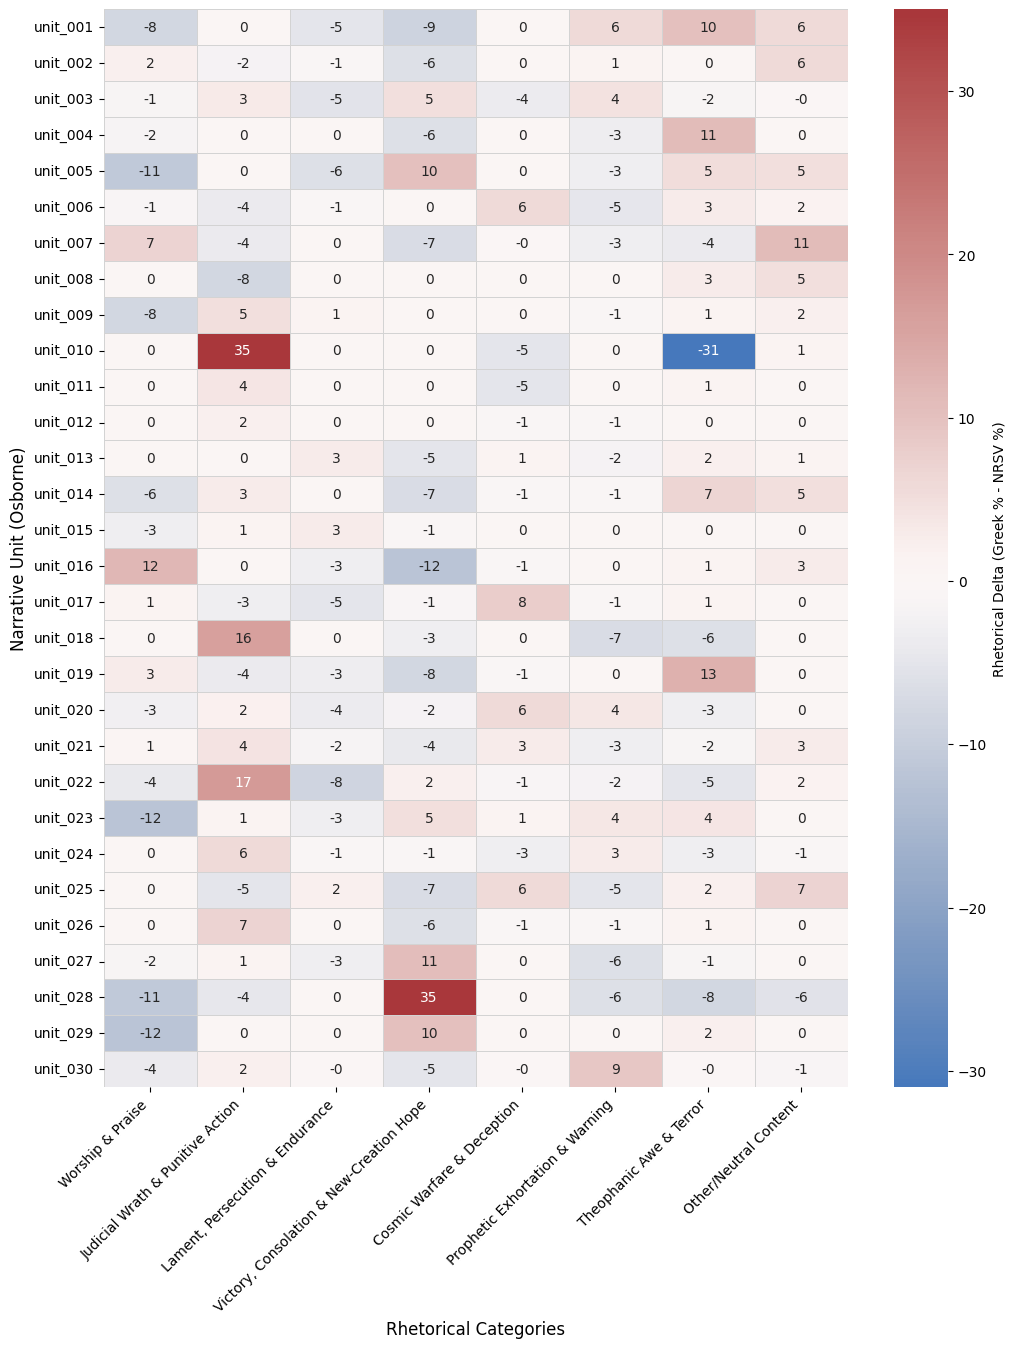

In [3]:
# @title Analysis of the translation_drift
# ╔═══════════════════════════════════════════════════════════╗
# ║ Notebook 04: Comparative Translation Drift Analysis       ║
# ╚═══════════════════════════════════════════════════════════╝
# This notebook compares the rhetorical profiles of the Greek (SBLGNT)
# and English (NRSV) texts.

# --- 1️⃣  Setup and Imports ---
import json
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os

# Configure fonts globally to avoid warnings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Calibri']
mpl.rcParams['axes.unicode_minus'] = False

# Add the current directory to the path to find the src folder
# Use './' if src is in the same directory as the notebook (e.g., /content/)
sys.path.append('../')

from src.corpus_parser import load_json
from src.analysis_utils import parse_data_to_df
from src.config import *
CATEGORIES = ANALYTICAL_CONCEPTS_LIST 

# Define Paths (Adjust PATH_BASE if your structure changes)
PATH_BASE = "./" 

GREEK_JSON_FILE = os.path.join(PATH_RESULTS, 'gemini_osborne_greek.json')
NRSV_JSON_FILE = os.path.join(PATH_RESULTS, 'gemini_osborne_nrsv.json')

# Function to sanitize text for display
def sanitize_text_data(df):
    """Remove or replace problematic characters in DataFrame labels"""
    def clean_text(text):
        if isinstance(text, str):
            return text.replace('\uFFFD', '?')
        return text
    
    # Clean column labels
    if hasattr(df, 'columns'):
        df.columns = [clean_text(x) for x in df.columns]
    return df

# --- 2️⃣  Load and Prepare Data ---
try:
    df_greek = parse_data_to_df(load_json(GREEK_JSON_FILE))
    df_nrsv = parse_data_to_df(load_json(NRSV_JSON_FILE))
    print("✅ Successfully loaded and parsed Greek and NRSV data.")
except Exception as e:
    print(f"❌ Error loading files. Ensure they exist in the correct path. Error: {e}")
    df_greek, df_nrsv = None, None

# --- 3️⃣  Calculate Rhetorical Deltas ---
if df_greek is not None and df_nrsv is not None:
    # Merge the two dataframes on their index (unit_id)
    df_merged = df_greek.merge(df_nrsv, left_index=True, right_index=True, suffixes=('_Greek', '_NRSV'))
    verse_ranges = df_merged['verse_range_Greek']

    # Calculate the deltas (Greek % - NRSV %)
    df_deltas = pd.DataFrame(index=df_merged.index)
    for cat in CATEGORIES:
        df_deltas[cat] = df_merged[f'{cat}_Greek'] - df_merged[f'{cat}_NRSV']
    
    # Sanitize data
    df_deltas = sanitize_text_data(df_deltas)

    print("✅ Calculated rhetorical deltas.")
    print("\n--- Sample of Calculated Deltas ---")
    display(df_deltas.head())

# --- 4️⃣  Generate Headline Divergences Table ---
if 'df_deltas' in locals():
    MATERIAL_DELTA_THRESHOLD = 8.0
    divergences = []

    for unit_id, row in df_deltas.iterrows():
        max_abs_delta_cat = row.abs().idxmax()
        delta_value = row[max_abs_delta_cat]

        if abs(delta_value) >= MATERIAL_DELTA_THRESHOLD:
            divergences.append({
                'Pericope (Osborne Unit)': verse_ranges[unit_id],
                'Category with Largest Δ': max_abs_delta_cat,
                'Greek (%)': df_greek.loc[unit_id, max_abs_delta_cat],
                'NRSV (%)': df_nrsv.loc[unit_id, max_abs_delta_cat],
                'Δ (pp)': delta_value
            })

    df_headline_table = pd.DataFrame(divergences)
    df_headline_table = df_headline_table.sort_values(by='Δ (pp)', key=abs, ascending=False).reset_index(drop=True)
    df_headline_table.insert(0, 'Rank', df_headline_table.index + 1)
    
    # Sanitize data
    df_headline_table = sanitize_text_data(df_headline_table)

    print("\n--- Headline Quantitative Divergences Table (Top 5) ---")
    # Display only the top 5 as requested in the paper
    display(df_headline_table.head(5))

    # Save the full headline table to a JSON file
    try:
        df_headline_table.to_json(os.path.join(PATH_RESULTS, 'headline_divergences.json'), orient='records', indent=4)
        print(f"\n✅ Full headline table saved to '{os.path.join(PATH_RESULTS, 'headline_divergences.json')}'")
    except Exception as e:
        print(f"\n❌ Error saving headline table to JSON: {e}")

# --- 5️⃣  Visualize Rhetorical Drift (Heatmap) ---
if 'df_deltas' in locals():
    try:
        # Reset matplotlib settings to avoid interference
        plt.rcdefaults()
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Calibri']
        
        plt.style.use('default')
        plt.figure(figsize=(12, 14))

        heatmap = sns.heatmap(
            df_deltas,
            annot=True,
            fmt=".0f",
            cmap='vlag',
            linewidths=.5,
            linecolor='lightgray',
            center=0,
            cbar_kws={'label': 'Rhetorical Delta (Greek % - NRSV %)'}
        )

        # Title removed from plot
        heatmap.set_xlabel('Rhetorical Categories', fontsize=12)
        heatmap.set_ylabel('Narrative Unit (Osborne)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        # Change file extension to jpg
        FIGURE_PATH = os.path.join(PATH_FIGURES, 'delta_heatmap_greek_vs_nrsv.jpg')
        # If the figures directory doesn't exist, create it
        os.makedirs(os.path.dirname(FIGURE_PATH), exist_ok=True)

        # Save the figure with high DPI
        plt.savefig(FIGURE_PATH, dpi=300, bbox_inches='tight')
        
        # Print statement that includes the former title
        print(f"\n✅ Figure: Delta Heatmap (Rhetorical Drift: Greek (SBLGNT) vs. English (NRSV) Scores) saved to '{FIGURE_PATH}'")
        
        # Display the figure
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Error generating or saving heatmap: {e}")